In [ ]:
#Question7

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings("ignore")

# Load the dataset
df = pd.read_csv("C:/Users/19452/Downloads/Air_line_Delay_Cause.csv")

# Data Preprocessing: Convert categorical variables to numeric
label_encoder = LabelEncoder()
df['carrier'] = label_encoder.fit_transform(df['carrier'])
df['airport'] = label_encoder.fit_transform(df['airport'])

# Fill any missing values with zero
df.fillna(0, inplace=True)

In [2]:
import prophet

00:53:50 - cmdstanpy - INFO - Chain [1] start processing
00:53:50 - cmdstanpy - INFO - Chain [1] done processing


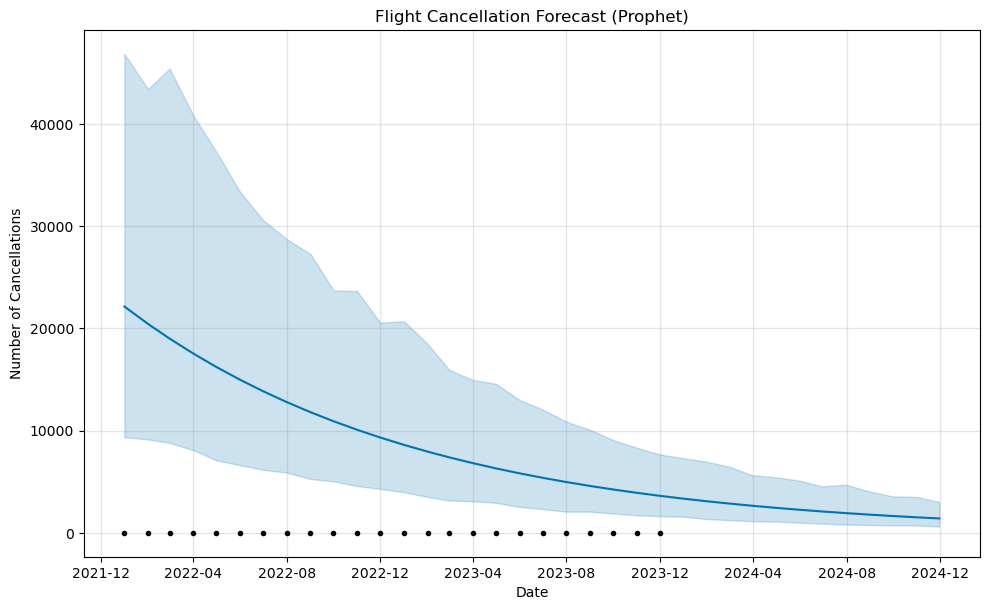

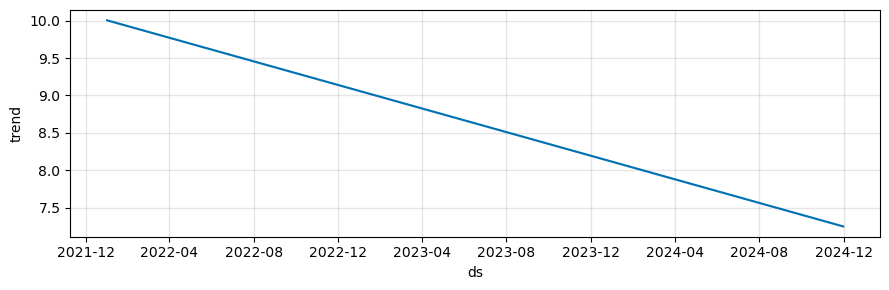

In [6]:
import pandas as pd
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt

# Clean and prepare data
df_prophet = df.groupby(['year', 'month'])['arr_cancelled'].sum().reset_index()

# Filter out invalid 'year' and 'month' values
df_prophet = df_prophet[
    (df_prophet['year'] > 0) & 
    (df_prophet['month'] > 0) & 
    (df_prophet['month'] <= 12)
]

# Convert year and month to a proper date
df_prophet['date'] = pd.to_datetime(
    df_prophet['year'].astype(int).astype(str) + '-' + 
    df_prophet['month'].astype(int).astype(str) + '-01',
    errors='coerce'  # Handle invalid parsing gracefully
)

# Drop rows where 'date' could not be created
df_prophet = df_prophet.dropna(subset=['date'])

# Rename columns for Prophet
df_prophet = df_prophet[['date', 'arr_cancelled']].rename(columns={'date': 'ds', 'arr_cancelled': 'y'})

# Apply log transformation to ensure positivity
df_prophet['y'] = np.log1p(df_prophet['y'])  # log1p handles log(0) gracefully

# Initialize the Prophet model
model = Prophet()

# Fit the model
model.fit(df_prophet)

# Create a dataframe for future predictions
future = model.make_future_dataframe(periods=12, freq='M')  # Forecast 12 months ahead

# Predict
forecast = model.predict(future)

# Reverse the log transformation and clamp negative values
forecast['yhat'] = np.expm1(forecast['yhat'])  # Reverse log1p
forecast['yhat_lower'] = np.expm1(forecast['yhat_lower'])
forecast['yhat_upper'] = np.expm1(forecast['yhat_upper'])

# Ensure no negative values
forecast[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat', 'yhat_lower', 'yhat_upper']].clip(lower=0)

# Plot the forecast
fig = model.plot(forecast)
plt.title("Flight Cancellation Forecast (Prophet)")
plt.xlabel("Date")
plt.ylabel("Number of Cancellations")
plt.show()

# Optional: Plot the components (trend, seasonality)
fig2 = model.plot_components(forecast)
plt.show()
